In [ ]:
!echo y | pip uninstall h5py
!pip install h5py==3.1.0
!pip install openfermion openfermionpyscf qulacs scipy

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
from openfermion.transforms import get_fermion_operator, jordan_wigner, bravyi_kitaev, symmetry_conserving_bravyi_kitaev
from openfermion.ops import FermionOperator
from pyscf import gto, scf, tools
from qchem_util import get_molecular_hamiltonian_from_fcidump
from qulacs.observable import create_observable_from_openfermion_text
from qulacs import QuantumState, QuantumCircuit
from qulacs.gate import X, RY, CNOT, merge, RY

# 量子変分固有値法（VQE)を用いた基底状態計算

さて、ここまでで、量子コンピュータ上に電子の波動関数やハミルトニアンを載せる方法を学んだ。
分子のエネルギー計算を量子コンピュータで実行するには、あとは、
量子コンピュータを使って、以下の固有値問題をどう解くかがわかれば良い。
$$H\Psi = E\Psi$$


この方法もハミルトニアンの変換法と同様に複数存在する。
将来的にどの計算法がデファクトスタンダードとなるかは、まだ未知数であるが、
代表的なものは位相推定法（Phase Estimation Algorithm, PEA)と変分量子固有値法(Variational Quantum Eigensolver, VQE)の２つである。
PEAは厳密解を多項式時間で解くことができるアルゴリズムであり、
古典アルゴリズムに対する優位性が保証された方法となっている。
しかし、PEAの量子回路は非常に深くなるため、水素分子のようなミニマルな系以外では、NISQ上で動作することは望めない。

これに対して、VQEは量子回路$U(\theta)$を使って、求めたい量子状態の近似波動関数$\Psi_T(\theta)$を表現し、量子回路のパラメータ$\theta$は、$E_T(\theta) = <\Phi_T(\theta) | H | \Phi_T(\theta) > $が最小化されるように古典コンピュータ上で決定する。VQEで用いる$U(\theta)は$PEAに比べて浅い回路で良く、NISQでも（ある程度）動作する。

「03_量子演算を変分的に分解する」や「08_簡単な量子回路学習を実行してみる 」では、コスト関数の最小化をおこなったが、VQEもコスト関数にエネルギーを使って同様のことをおこなっている。


## 復習: 水素分子のハミルトニアンをqubit表現で用意

さて、これまでの復習になるが、水素分子のハミルトニアンを用意してみる。


In [12]:
# 水素分子、H-H距離は0.74Å と設定。STO-3GというGaussian型の原子基底関数を使用。
mol_h2 = gto.M(atom = 'H 0 0 0; H 0 0 0.74', basis = 'sto-3g')
# この水素分子の基底状態を平均場近似（Hartree-Fock theory)で計算してみる。
mean_field_wavefunction = scf.RHF(mol_h2)
mean_field_wavefunction.verbose = 0
hf_energy = mean_field_wavefunction.kernel()
# 第二量子化された電子のハミルトニアンを構築し、fcidump 形式で保存
tools.fcidump.from_scf(mean_field_wavefunction, 'fcidump.rhf') 
# OpenFermionに第二量子化されたハミルトニアンをロード
fermion_hamiltonian = get_fermion_operator(get_molecular_hamiltonian_from_fcidump('fcidump.rhf'))
# Jordan-Wigner変換をおｋなう
jw_qubit_hamiltonian = jordan_wigner(fermion_hamiltonian)
print (jw_qubit_hamiltonian)

Parsing fcidump.rhf
(-0.09706626816762906+0j) [] +
(-0.04530261550379928+0j) [X0 X1 Y2 Y3] +
(0.04530261550379928+0j) [X0 Y1 Y2 X3] +
(0.04530261550379928+0j) [Y0 X1 X2 Y3] +
(-0.04530261550379928+0j) [Y0 Y1 X2 X3] +
(0.1714128264477691+0j) [Z0] +
(0.16868898170361213+0j) [Z0 Z1] +
(0.1206252348339042+0j) [Z0 Z2] +
(0.16592785033770346+0j) [Z0 Z3] +
(0.1714128264477692+0j) [Z1] +
(0.16592785033770346+0j) [Z1 Z2] +
(0.1206252348339042+0j) [Z1 Z3] +
(-0.22343153690813558+0j) [Z2] +
(0.1744128761226158+0j) [Z2 Z3] +
(-0.2234315369081356+0j) [Z3]


## 量子回路上でのHartree-Fock状態の用意

さて、VQEの量子回路$U(\theta)$は、何かしらの初期波動関数$|\Psi_0>$に作用して、近似波動関数を生成する。
$$|\Psi(\theta)_T> = U(\theta) |\Psi_0> $$
初期波動関数をどうするかは難しい問題であるが、Hartree-Fock波動関数は重ね合わせがない状態のため、簡単に用意でき、かつ既にみたように化学の問題においては99%程度の精度を持っている、という点で優れている。

では、qulacsを使って、Hartree-Fock状態を用意しよう。


In [13]:
n_qubit = 4 
hf_state = QuantumState(n_qubit) # 4qubitの量子状態を用意。この時点では|0000> 
hf_state.set_computational_basis(int('0b0011',2)) # |0011>を用意

STO-3G基底関数を使った時の水素分子のHartree-Fockエネルギー -1.1167593073964248 が正しく得られているか確認してみよう。
まず、OpenFermion形式で得られたハミルトニアンをqulacsで使える形式に変換する。

In [14]:
qulacs_hamiltonian = create_observable_from_openfermion_text(str(jw_qubit_hamiltonian))

hf_stateを使って、qulacs_hamiltonianの期待値を計算すれば、Hartree-Fockエネルギーが計算できる。

In [15]:
qulacs_hamiltonian.get_expectation_value(hf_state)

-1.116759307396426

この値は、PySCFで計算した、Hartree-Fock Energy -1.1167593073964248 と一致していることが見て取れる。

# 波動関数を表す量子回路$U(\theta)$の用意

波動関数のモデルのことを物理では、ansatzと呼ぶ。
このansatzが、VQEの場合、量子回路$U(\theta)$となっている。
どういった 分子の波動関数に対してどういった$U(\theta)$がいいかは今も研究がおこなわれている最中であり、決定打となるようなものはまだ存在しない（と少なくとも思われている）。

ここでは、Gard et al. による粒子数を保存する回路を用いることにしよう。
（https://www.nature.com/articles/s41534-019-0240-1)



In [16]:
def create_A_gate(theta, target_two_qubits):
  first = target_two_qubits[0]
  second = target_two_qubits[1]
  CNOT02 = CNOT(first, second)
  CRY0 = RY(first, theta+np.pi/2)
  CRY0_minus = RY(first, -(theta+np.pi/2))
  CNOT20 = CNOT(second, first)
  return merge(merge(merge(merge(CNOT02, CRY0), CNOT20), CRY0_minus), CNOT02)

In [17]:
create_A_gate(0.0, [0, 2])

 *** gate info *** 
 * gate name : DenseMatrix
 * target    : 
 0 : commute       
 2 : commute       
 * control   : 
 * Pauli     : no
 * Clifford  : no
 * Gaussian  : no
 * Parametric: no
 * Diagonal  : no
 * Matrix
          (1,0)           (0,0)           (0,0)           (0,0)
          (0,0)           (1,0) (2.22045e-16,0)           (0,0)
          (0,0) (2.22045e-16,0)          (-1,0)           (0,0)
          (0,0)           (0,0)           (0,0)           (1,0)

この粒子数保存回路は、2つの量子ビットに作用し、１電子の移動（励起）を表現できる。
この回路を組み合わせて作ったアンザッツ(ansatz)を使ってコスト関数（エネルギー）を計算するルーチンを以下のように用意する。

In [24]:
n_repeat = 2 #量子回路の深さ
def cost(parameters):
    #初期波動関数の用意
    n_qubit = 4 
    state = QuantumState(n_qubit) # 4qubitの量子状態を用意。この時点では|0000> 
    state.set_computational_basis(int('0b0011',2)) # |0011>を用意
    #ansatz(量子回路を用意)
    num_paras = len(parameters)
    ansatz = QuantumCircuit(n_qubit)
    for i in range(n_repeat):
        idx = 2*i 
        ansatz.add_gate(create_A_gate(parameters[idx], [0, 2]))
        ansatz.add_gate(create_A_gate(parameters[idx+1], [1, 3]))
        ansatz.add_gate(create_A_gate(parameters[idx], [1, 2]))
    #近似波動関数の生成
    ansatz.update_quantum_state(state)
    return qulacs_hamiltonian.get_expectation_value(state) #エネルギーを返す。

このコスト関数を最適化すれば、VQE計算を実行したことになる。
では、実行してみよう。

Convderged VQE Energy (in hartree) -1.1371944668015292
c.f., Full CI Energy (in hartree)  -1.1372838344885023


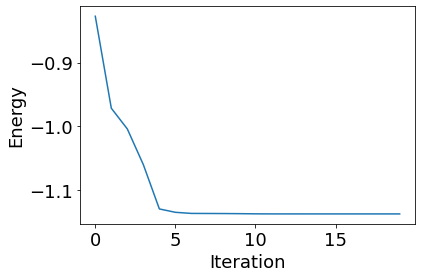

In [25]:
import scipy.optimize

cost_history = []

#パラメータの初期値
init_theta_list = [np.random.random() for i in range(n_repeat*2)]
#init_theta_list = [0.1 for i in range(n_repeat*2)]
cost_history.append(cost(init_theta_list))

method = "BFGS"
options = {"disp": True, "maxiter": 50, "gtol": 1e-6}

opt = scipy.optimize.minimize(cost, init_theta_list,
               method=method,
               callback=lambda x: cost_history.append(cost(x)))

#print (cost_history)
print ("Convderged VQE Energy (in hartree)", cost_history[-1])
print ("c.f., Full CI Energy (in hartree)  -1.1372838344885023")
plt.rcParams["font.size"] = 18
plt.plot(cost_history)
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.show()

VQE Energyが 0.001 hartree以下の誤差で、Full CIのエネルギーを再現していることが見て取れる。n_repeatの数を増やして、もっと深い量子回路にすれば、Full CIと厳密に一致する解を得ることができる。逆に、n_repeatの数を減らすと(i.e., 1)、精度が低下することが確認できるので、実行してみよう。
